# Exploratory Data Analysis

In this notebook, we are going to explore the energy consumption data we loaded into the **data** directory. With the ETL notebook, we only kept 3 columns :
- **datetime** : date and time of record
- **prediction_unit_id** : a unique identifier for the ``county``, ``is_business``, and ``product_type`` combination (we removed these columns in the ETL script). Note that new prediction units can appear or dissappear with time, and so in the test set.
- **consumption** : the consumption amount for the relevant segment (prediction unit) for the corresponding hour.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# Read the data

In [20]:
df = pd.read_csv("./data/consumption.csv")
print(f"data shape : {df.shape}")
df.head()

data shape : (1009176, 3)


datetime  prediction_unit_id  consumption
0  2021-09-01 00:00:00                   0       96.590
1  2021-09-01 00:00:00                   1       17.314
2  2021-09-01 00:00:00                   2      656.859
3  2021-09-01 00:00:00                   3       59.000
4  2021-09-01 00:00:00                   4      501.760

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009176 entries, 0 to 1009175
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   datetime            1009176 non-null  object 
 1   prediction_unit_id  1009176 non-null  int64  
 2   consumption         1008912 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 23.1+ MB


In [4]:
print("unique segments : \n{}".format(df["prediction_unit_id"].unique()))
print()
print("number of segments : {}".format(df["prediction_unit_id"].unique().size))

unique segments : 
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]

number of segments : 69


In [5]:
print("start date : {}".format(df["datetime"].min()))
print("end date   : {}".format(df["datetime"].max()))

start date : 2021-09-01 00:00:00
end date   : 2023-05-31 23:00:00


In [6]:
# Let's look at the unique date ranges
unique_date_ranges = pd.concat(
    [
        df.groupby(by="prediction_unit_id")["datetime"].min().rename("start date"),
        df.groupby(by="prediction_unit_id")["datetime"].max().rename("end date"),
    ],
    axis=1,
).drop_duplicates()  # drop rows with same start and end dates
unique_date_ranges.sort_values(by="start date")

start date             end date
prediction_unit_id                                          
0                   2021-09-01 00:00:00  2023-05-31 23:00:00
26                  2021-09-01 00:00:00  2023-03-29 23:00:00
41                  2021-09-01 00:00:00  2023-05-15 23:00:00
44                  2021-09-01 00:00:00  2023-05-27 23:00:00
47                  2021-09-01 00:00:00  2023-05-24 23:00:00
61                  2021-10-01 00:00:00  2023-05-31 23:00:00
64                  2021-12-01 00:00:00  2023-05-31 23:00:00
65                  2022-01-01 00:00:00  2023-05-31 23:00:00
67                  2022-02-01 00:00:00  2023-05-31 23:00:00
68                  2022-11-01 00:00:00  2023-05-31 23:00:00

In [7]:
# sorted by end date
unique_date_ranges.sort_values(by="end date")

start date             end date
prediction_unit_id                                          
26                  2021-09-01 00:00:00  2023-03-29 23:00:00
41                  2021-09-01 00:00:00  2023-05-15 23:00:00
47                  2021-09-01 00:00:00  2023-05-24 23:00:00
44                  2021-09-01 00:00:00  2023-05-27 23:00:00
0                   2021-09-01 00:00:00  2023-05-31 23:00:00
61                  2021-10-01 00:00:00  2023-05-31 23:00:00
64                  2021-12-01 00:00:00  2023-05-31 23:00:00
65                  2022-01-01 00:00:00  2023-05-31 23:00:00
67                  2022-02-01 00:00:00  2023-05-31 23:00:00
68                  2022-11-01 00:00:00  2023-05-31 23:00:00

# Missing values

In [8]:
df.isna().sum()

datetime                0
prediction_unit_id      0
consumption           264
dtype: int64

At first glance, there are very few missing values in the dataset.

# Find missing dates

In [9]:
series = []
for prediction_unit_id in df["prediction_unit_id"].unique():
    s = df[df["prediction_unit_id"] == prediction_unit_id].set_index("datetime")
    s.index = pd.to_datetime(s.index)
    date_range = pd.date_range(start=s.index.min(), end=s.index.max(), freq="h")
    missing_dates = date_range[~date_range.isin(s.index)]
    s = s.reindex(date_range)
    s.index.name = "datetime"
    s["prediction_unit_id"] = prediction_unit_id
    series.append(s)

In [10]:
df_ = df.copy()
df = pd.concat(series).reset_index()
df.head()

datetime  prediction_unit_id  consumption
0 2021-09-01 00:00:00                   0       96.590
1 2021-09-01 01:00:00                   0       77.691
2 2021-09-01 02:00:00                   0       91.594
3 2021-09-01 03:00:00                   0       87.955
4 2021-09-01 04:00:00                   0       88.184

In [11]:
df.isna().sum()

datetime                  0
prediction_unit_id        0
consumption           21360
dtype: int64

In [12]:
df.isna().mean()

datetime              0.000000
prediction_unit_id    0.000000
consumption           0.020732
dtype: float64

We can see there are much more missing values when adding the missing dates and times in the dataset.

In [13]:
# missing values per segment
nans_per_unit = df[df["consumption"].isna()].groupby("prediction_unit_id")[
    "datetime"
].count().sort_values(ascending=False).rename("NaN counts")
nans_per_unit

prediction_unit_id
41    8858
26    3819
68    3432
47    3147
44    1108
      ... 
62       4
64       3
65       3
66       3
67       3
Name: NaN counts, Length: 69, dtype: int64

In [14]:
nans_per_unit[nans_per_unit > 4]

prediction_unit_id
41    8858
26    3819
68    3432
47    3147
44    1108
21     748
Name: NaN counts, dtype: int64

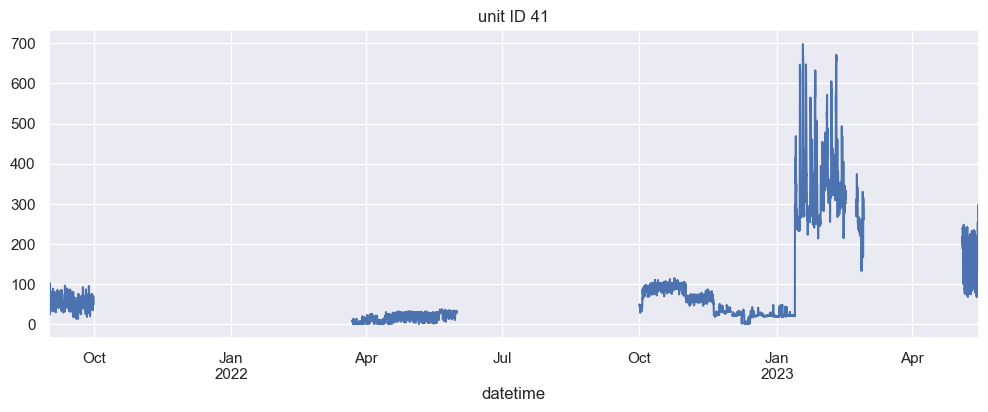

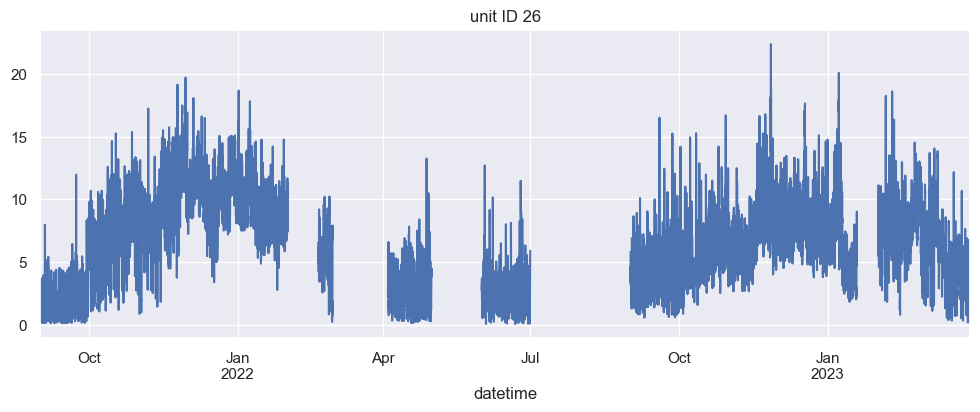

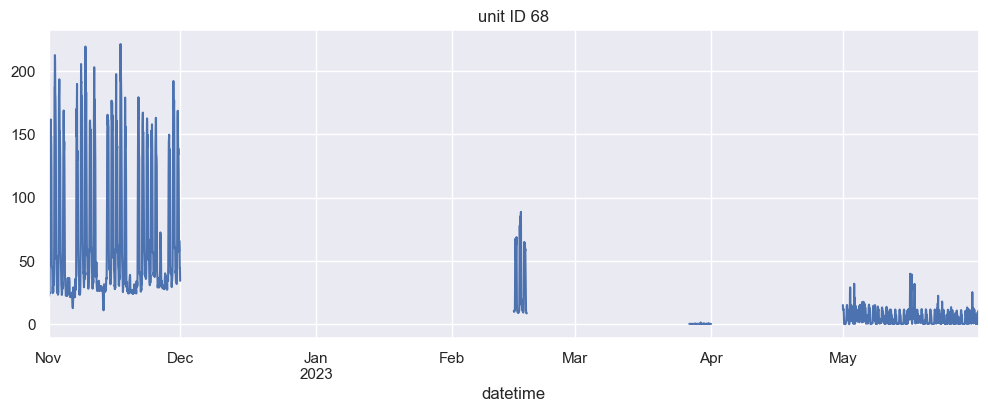

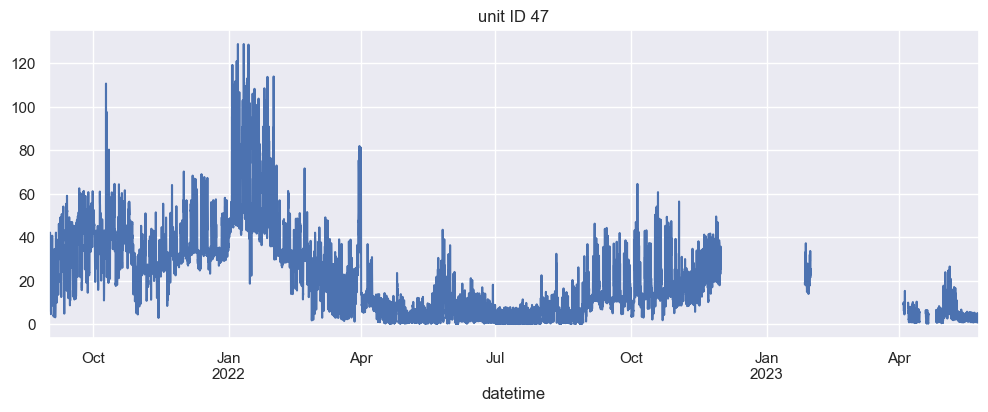

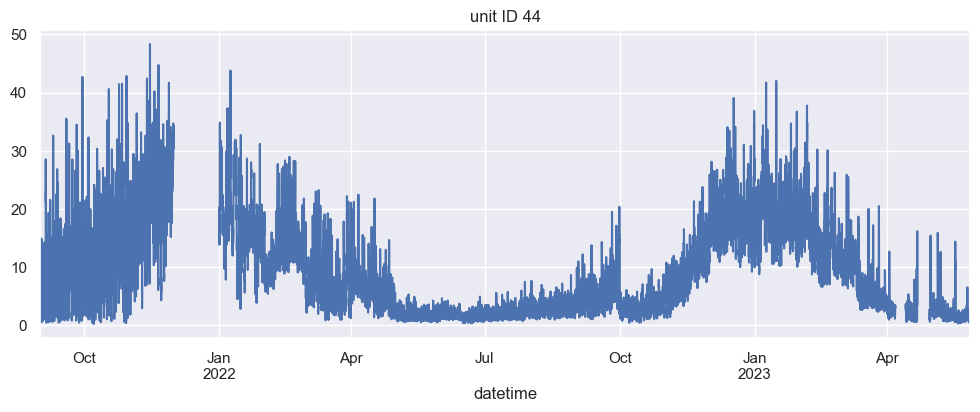

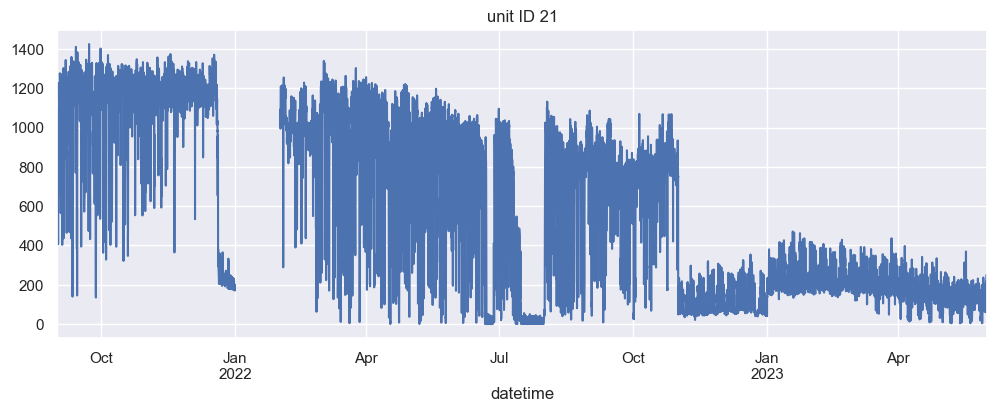

In [15]:
# Plot data for units that have more than 4 missing values
for prediction_unit_id in nans_per_unit[nans_per_unit > 4].index:
    s = df[df["prediction_unit_id"] == prediction_unit_id].set_index("datetime")
    plt.figure(figsize=(12,4))
    plt.title(f"unit ID {prediction_unit_id}")
    s["consumption"].plot()

In [ ]:
# # cell copied from : https://www.kaggle.com/code/tsunotsuno/enefit-eda-baseline

# # Create a map object, centered around the average coordinates of Estonia
# folium_map = folium.Map(location=[58.595272, 25.013607], zoom_start=7)

# # Plot county point plot (red)
# for county, coords in counties_locations.items():
#     folium.CircleMarker(
#         location=[coords[0], coords[1]], radius=5, color="red", fill=True
#     ).add_child(folium.Popup(county)).add_to(folium_map)

# # Plot weather point (orange)
# for row in weather_point.rows(named=True):
#     folium.CircleMarker(
#         location=[row["latitude"], row["longitude"]], radius=1, color="orange"
#     ).add_child(
#         folium.Popup(str(row["latitude"]) + ", " + str(row["longitude"]))
#     ).add_to(
#         folium_map
#     )

# # Display
# folium_map